# Normal Estimation from Depth Image

In [1]:
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
from pydrake.all import RigidTransform, RotationMatrix, StartMeshcat

from manipulation import running_as_notebook
from manipulation.meshcat_utils import AddMeshcatTriad
from manipulation.mustard_depth_camera_example import MustardExampleSystem

/home/oo/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


# Problem Description
In the lecture, we learned about estimating the point cloud normal vectors and surface curvations. For this exercise, you will investigate a slightly different approach. In particular, you will exploit the structure already presented in a depth image to avoid computing nearest neighbors. 

**These are the main steps of the exercise:**
1. Implement the `estimate_normal_by_nearest_pixels` method.
2. Come up with an example that breaks the `estimate_normal_by_nearest_pixels` method.

Run the cell below to set up the simulation environment.

In [3]:
class NormalEstimation:
    def __init__(self):
        diagram = MustardExampleSystem()
        context = diagram.CreateDefaultContext()

        # setup
        meshcat.SetProperty("/Background", "visible", False)

        # getting data
        self.point_cloud = diagram.GetOutputPort("camera0_point_cloud").Eval(context)
        self.rgb_im = diagram.GetOutputPort("camera0_rgb_image").Eval(context).data
        self.depth_im_read = (
            diagram.GetOutputPort("camera0_depth_image").Eval(context).data.squeeze()
        )
        self.depth_im = deepcopy(self.depth_im_read)
        self.depth_im[self.depth_im == np.inf] = 10.0
        label_im = (
            diagram.GetOutputPort("camera0_label_image").Eval(context).data.squeeze()
        )
        self.mask = label_im == 1

        # camera specs
        cam0 = diagram.GetSubsystemByName("camera0")
        cam0_context = cam0.GetMyMutableContextFromRoot(context)
        self.X_WC = cam0.body_pose_in_world_output_port().Eval(cam0_context)
        self.cam_info = cam0.depth_camera_info()

    def project_depth_to_pC(self, depth_pixel, uv=None):
        """
        project depth pixels to points in camera frame
        using pinhole camera model
        Input:
            depth_pixels: numpy array of (nx3) or (3,)
        Output:
            pC: 3D point in camera frame, numpy array of (nx3)
        """
        # switch u,v due to python convention
        v = depth_pixel[:, 0]
        u = depth_pixel[:, 1]
        Z = depth_pixel[:, 2]
        # read camera intrinsics
        cx = self.cam_info.center_x()
        cy = self.cam_info.center_y()
        fx = self.cam_info.focal_x()
        fy = self.cam_info.focal_y()
        X = (u - cx) * Z / fx
        Y = (v - cy) * Z / fy
        pC = np.c_[X, Y, Z]
        return pC

    def plot_scanning_window(self, u_range, v_range):
        """
        visualize the scanning window
        u_range: (u_start, u_end)
        v_range: (v_start, v_end)
        u, v are the 1st and 2nd axis of the image array
        """
        # switch u, v range to get x, y
        x0, x1 = v_range
        y0, y1 = u_range
        fig, ax = plt.subplots()
        ax.imshow(self.depth_im)
        ax.add_patch(Rectangle((x0, y0), x1 - x0, y1 - y0, alpha=0.5, fc="r"))

    def vis_normals(self, normals):
        """ """
        for i in range(len(normals)):
            name = "normal_vec_{}".format(i)
            AddMeshcatTriad(meshcat, name, length=0.01, radius=0.001, X_PT=normals[i])


def bbox(img):
    a = np.where(img != 0)
    bbox = ([np.min(a[0]), np.max(a[0])], [np.min(a[1]), np.max(a[1])])
    return bbox


env = NormalEstimation()
mask = env.mask
depth_im = env.depth_im

INFO:drake:PackageMap: Downloading https://github.com/RobotLocomotion/models/archive/f418885f38be972b560f4f2661792f2800491bd7.tar.gz


The object of interest is the mustard bottle. Our goal in this exercise is to compute the estimate of point cloud normals of the mustard bottle from a depth image. The depth image is visualized below.

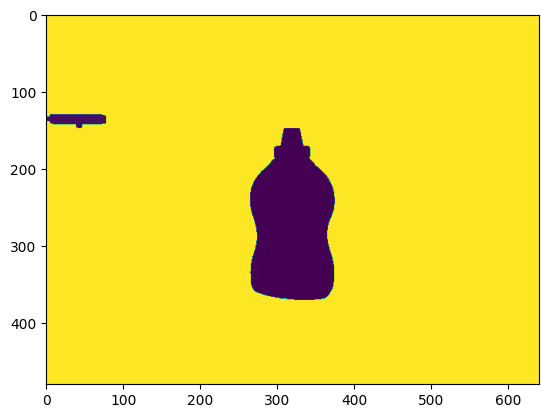

In [4]:
plt.imshow(depth_im)

The core idea of the approach is to exploit the fact that a depth image already includes spatial information among pixels. For example, for a selected pixel, the pixels that surround it are likely to be its nearest neighbors. Therefore, instead of computing nearest neighbors, we can instead use the nearest pixels in place of nearest neighbors. 

The cell below provides a sequence of screenshots of the method, where a square/rectangular window moves across the depth image. All pixels in the sliding window is used to compute the normal vector of the center point of the window. In your implementation below, you will use a smaller window and a smaller step size to get better accuracy.

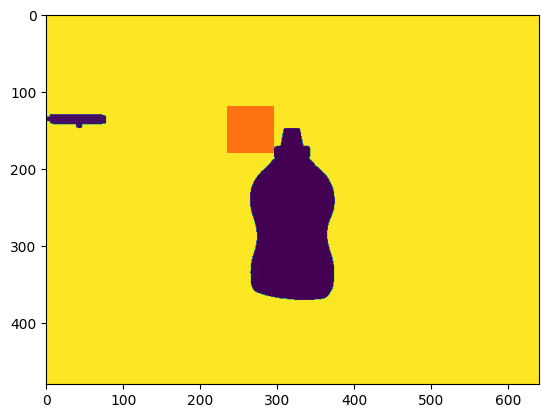

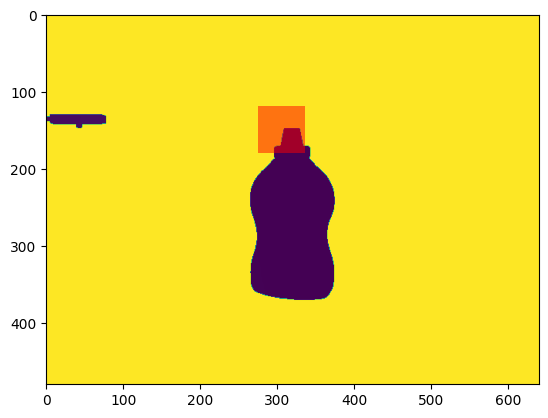

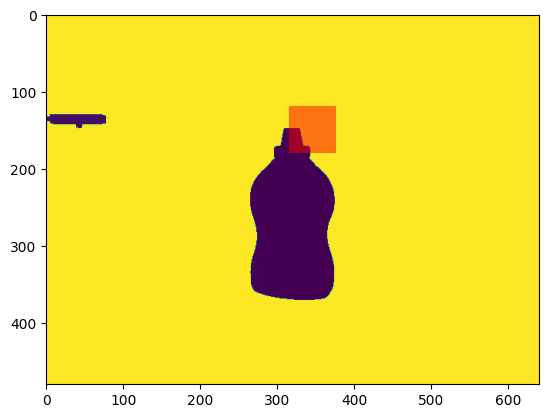

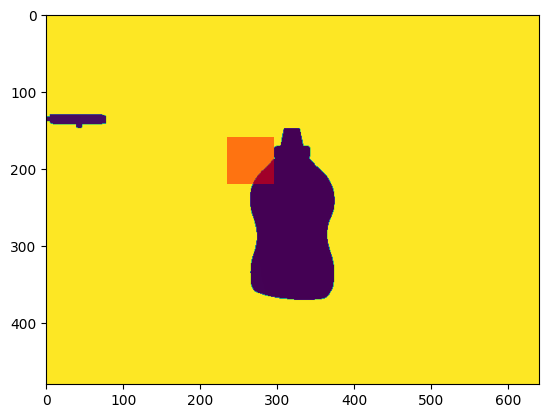

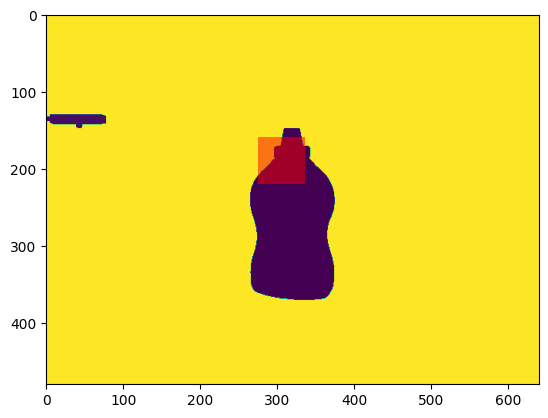

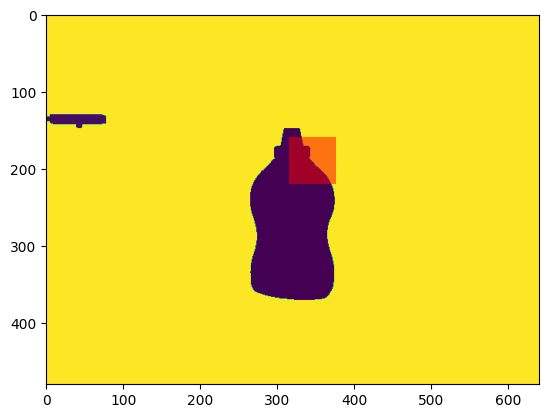

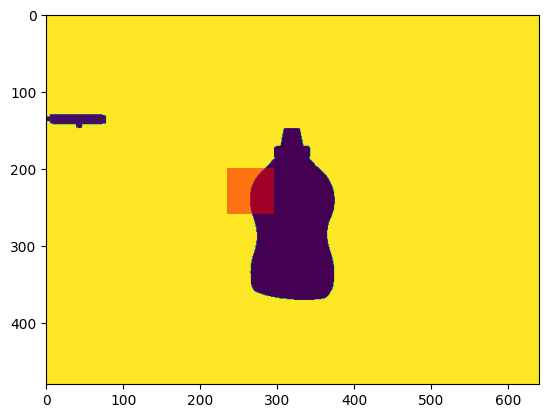

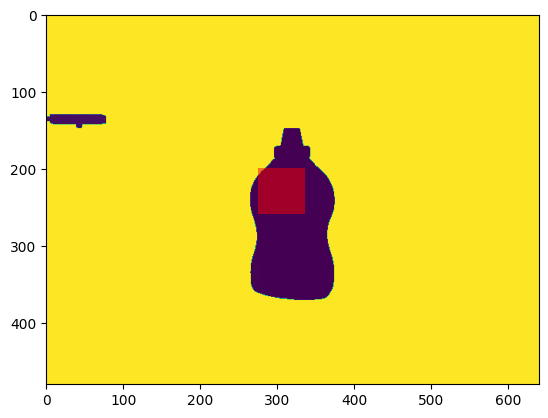

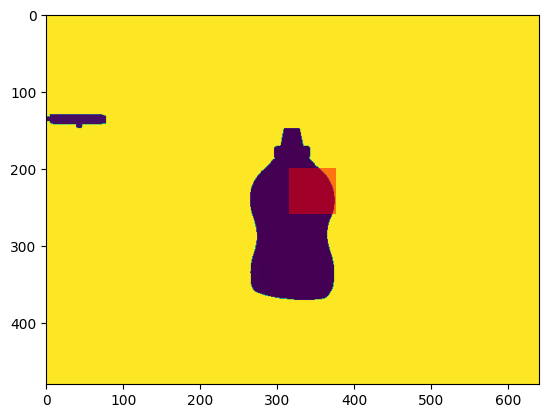

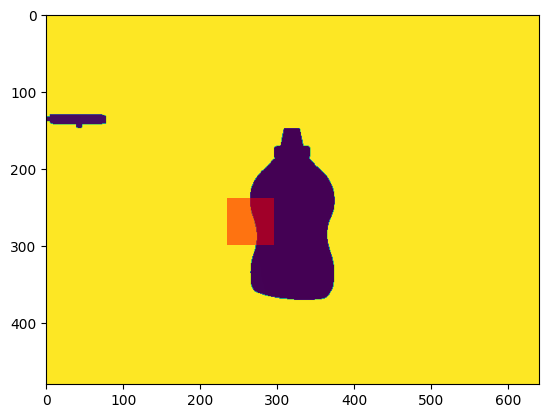

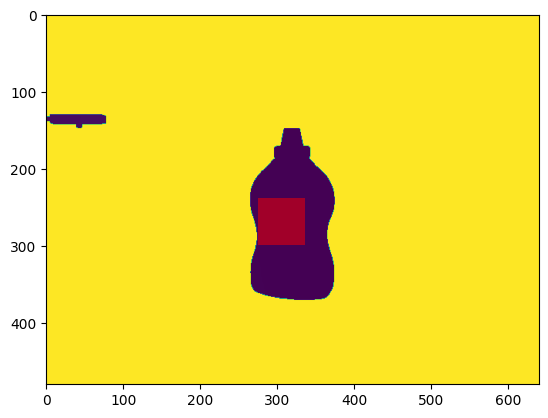

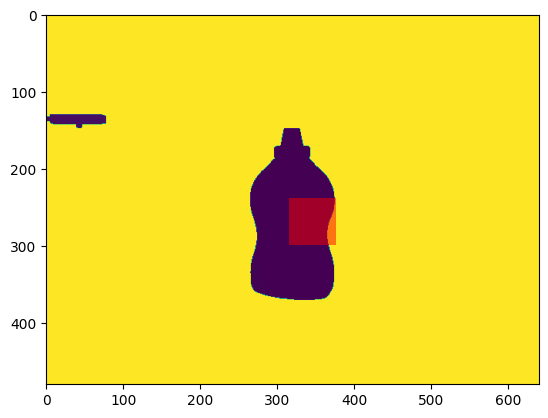

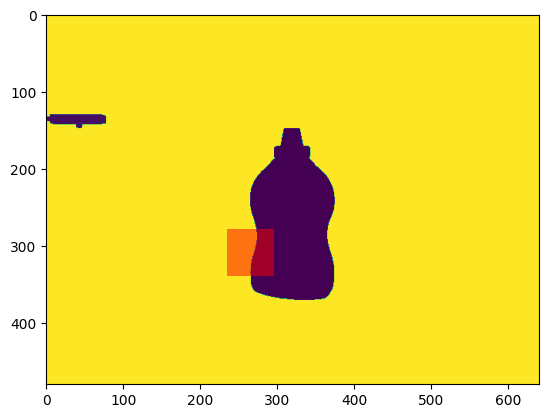

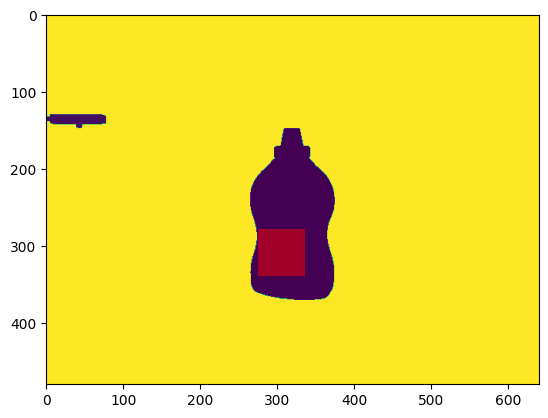

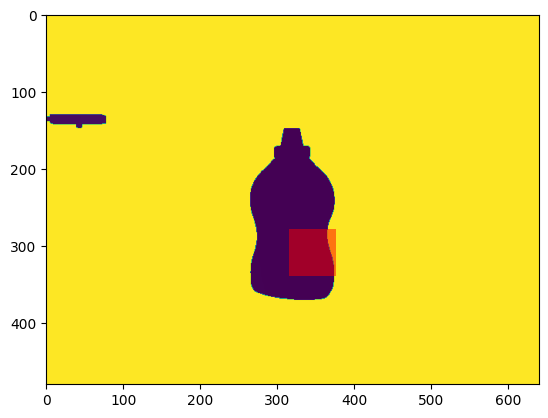

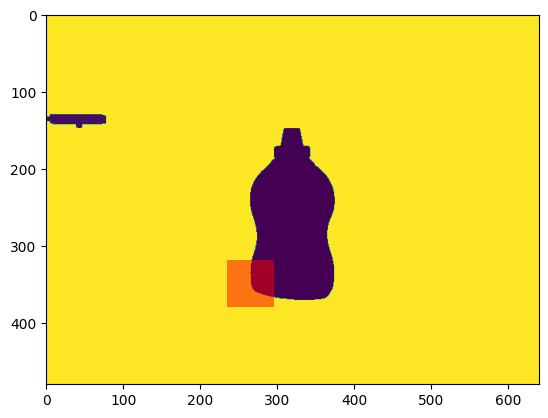

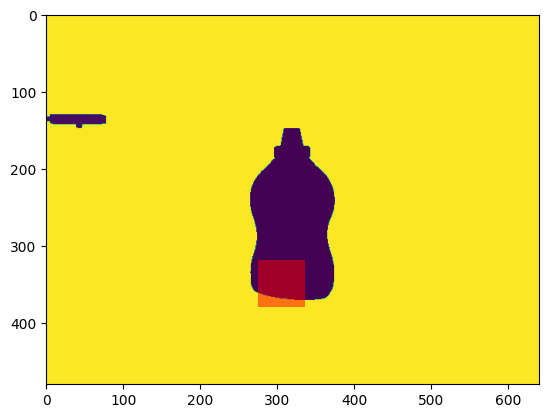

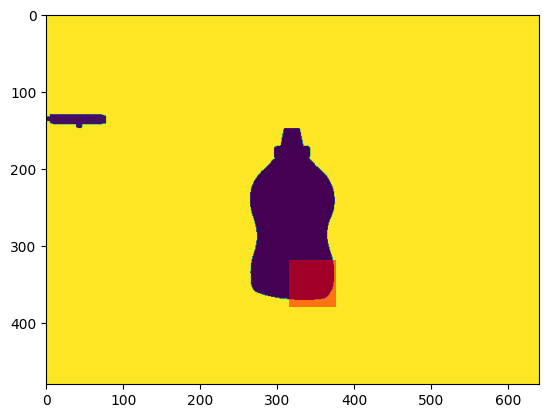

In [5]:
uv_step = 40
v_bound, u_bound = bbox(mask)

for v in range(v_bound[0], v_bound[1], uv_step):
    for u in range(u_bound[0], u_bound[1], uv_step):
        center = [v, u]
        u_length = 30
        v_length = 30
        if running_as_notebook:
            env.plot_scanning_window(
                [center[0] - v_length, center[0] + v_length + 1],
                [center[1] - u_length, center[1] + u_length + 1],
            )

## Mapping Depth Image to Point Cloud

Note that pixel indices of a depth image is not a valid position measurement in the 3D world. Fortunately, there is a simple mapping from pixel locations to poses in the 3D world, and it is called the [pinhole camera model](https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html). We have helped you map all pixels of the depth image to points in the camera frame in the cell below. In case you need to gain direct access to this mapping, please refer to the `project_depth_to_pC` method in the `NormalEstimation` class.

The diagram below is found from [OpenCV documentation](https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html). Note that the $u$ and $v$ directions are reversed in Python due to the difference in convention.

![](https://docs.opencv.org/3.4/pinhole_camera_model.png)

In [6]:
img_h, img_w = depth_im.shape
v_range = np.arange(img_h)
u_range = np.arange(img_w)
depth_u, depth_v = np.meshgrid(u_range, v_range)
depth_pnts = np.dstack([depth_v, depth_u, depth_im])
depth_pnts = depth_pnts.reshape([img_h * img_w, 3])
# point poses in camera frame
pC = env.project_depth_to_pC(depth_pnts)

## Computing Surface Normals by Nearest Pixels
Now you should be able to complete the implementation in the cell below. Note that locations of sliding windows are provided to you for the ease of grading. the pose of the depth camera is `X_WC`, **it is a different depth camera from the one shown in the meshcat visualizer**. 

**Complete the implementation of the `estimate_normal_by_nearest_pixels` below, make sure the +z axis of the normal frame points outward, toward the depth camera (different from the one shown in the meshcat visualizer)**

In [8]:
X_WC = env.X_WC


def estimate_normal_by_nearest_pixels(X_WC, pC, uv_step=10):
    """
    compute the surface normals from the nearest pixels (by a sliding window)
    Input:
        X_WC: RigidTransform of the camera in world frame
        pC: 3D points computed from the depth image in the camera frame
        uv_step: recommended step size for the sliding window (see codes below)
    Output:
        normals: a list of RigidTransforms of the normal frames in world frame.
                 The +z axis of the normal frame is the normal vector, it should
                 points outward (towards the camera)
    """
    normals = []
    v_bound, u_bound = bbox(mask)
    pC = pC.reshape(img_h, img_w, 3)
    for v in range(v_bound[0], v_bound[1], uv_step):
        for u in range(u_bound[0], u_bound[1], uv_step):
            # center of the window at depth_im[u,v]
            center = [v, u]
            u_length = 3
            v_length = 3
            # side of the window
            v_range = np.arange(max(v - v_length, 0), min(v + v_length + 1, img_h - 1))
            u_range = np.arange(max(u - u_length, 0), min(u + u_length + 1, img_w - 1))

            ###################
            # fill your code here
            ###################

    return normals

In [9]:
normals = estimate_normal_by_nearest_pixels(X_WC, pC)
env.vis_normals(normals)

## Normal Vector Estimation with Noisy Depth

The depth image tested in the first part of this exercise is a perfect depth image with no noise and missing values. Now imagine what will happen when noises and outliers are presented in the same depth image. 

**Illustrate a counter-example illustrating a case where the scanning window method cannot produce a good normal estimate.**

## How will this notebook be Graded?

If you are enrolled in the class, this notebook will be graded using [Gradescope](www.gradescope.com). You should have gotten the enrollement code on our announcement in Piazza. 

For submission of this assignment, you must do two things. 
- Download and submit the notebook `normal_estimation_depth.ipynb` to Gradescope's notebook submission section, along with your notebook for the other problems.
- Answer the counter-example in the written section of Gradescope as a part of your `pdf` submission. 

We will evaluate the local functions in the notebook to see if the function behaves as we have expected. For this exercise, the rubric is as follows:
- [4 pts] `estimate_normal_by_nearest_pixels` must be implemented correctly. 
- [2 pts] Provide a reasonable scenario that breaks the `estimate_normal_by_nearest_pixels` method.

In [ ]:
from manipulation.exercises.clutter.test_normal import TestNormal
from manipulation.exercises.grader import Grader

Grader.grade_output([TestNormal], [locals()], "results.json")
Grader.print_test_results("results.json")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=600b6296-e1a1-4c56-95c9-1a1516f29a41' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>